## *Jeu de données IRVE*
-------------------
# Indicateurs d'intégrité des données IRVE
     
### Présentation
Ce document identifie les points de recharge du jeu de données IRVE présentant des problèmes d'intégrité (*ex. une station associée à plusieurs coordonnées différentes, une coordonnée associée à plusieurs adresses*).   
    
Il complète l'analyse des données présentée dans [une note spécifique](http://nbviewer.org/github/loco-philippe/Environmental-Sensing/tree/main/python/Validation/irve/Analyse/IRVE_v3.ipynb).
     
### Sommaire
*(liens actifs sur jupyter Notebook ou [Nbviewer](http://nbviewer.org/github/loco-philippe/Environmental-Sensing/tree/main/python/Validation/irve/Analyse/IRVE_indicateurs.ipynb))*
- [Evolution des données (hors doublons)](#Evolution-des-données-(hors-doublons))
- [Défaut d'intégrité](#Défaut-d\'intégrité)
- [Localisation des stations comportant un écart](#Localisation-des-stations-comportant-un-écart)
- [Annexe - Fonctions utilisées](#Annexe---Fonctions-utilisées)

### Fichiers de données
Plusieurs fichiers liés aux défauts d'intégrité sont disponibles [ici](https://github.com/loco-philippe/Environmental-Sensing/blob/main/python/Validation/irve/Analyse/README.md):
- fichier csv des lignes résiduelles à traiter (IRVE_itinerance_residuel)
- fichier csv des données itinerance avec indicateur des données à corriger ou à ignorer (IRVE_itinerance_complet)
- fichier csv des données itinerance valides (IRVE_itinerance_valide)
- fichier csv des doublons (IRVE_itinerance_doublons)

In [5]:
indic = indicateurs()

## Evolution des données (hors doublons)
Le graphe ci-dessous présente l'évolution du nombre de points de recharge documentés dans le jeu de données avec une distinction entre les données présentant ou non des défauts d'intégrité.      
       
Il est à noter que malgré la structure complexe du jeu de données IRVE, le taux de défaut était à un niveau faible en début d'année (4%).

On observe néanmoins depuis fin juin, une diminution du nombre de points de recharge (passage de 45 000 à moins de 30 000) ainsi qu'une augmentation du taux de défauts (passage de 4% à 9%). 

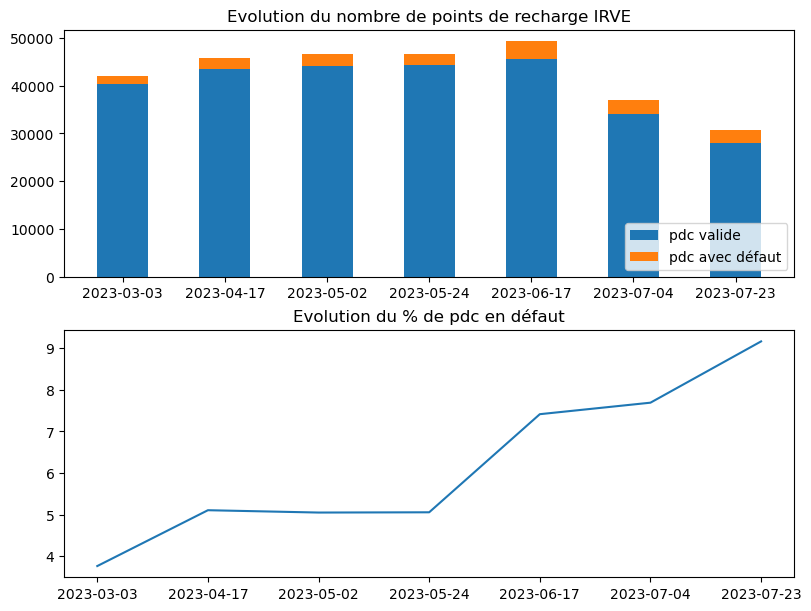

In [6]:
evolution(indic)

## Défaut d'intégrité
Les défauts d'intégrité découlent du [modèle de données](http://nbviewer.org/github/loco-philippe/Environmental-Sensing/tree/main/python/Validation/irve/Analyse/IRVE_modele.ipynb) associé au jeu de données : 
- défauts liés aux relations entre entités :
    - Un pdc est unique et associé à une ligne du jeu de données
    - Un pdc est intégré dans une et une seule station
    - Une station est opérée par un et un seul opérateur
    - Une station est hébergée par une et une seule enseigne
    - Une station a une et une seule localisation
- défauts liés entre un attribut et une entité :
    - Une station a un et un seul “nom_station”
    - Une station a une et une seule “implantation_station”
    - Une station a un et un seul “nbre_pdc”
    - Une station a un et un seule “condition_accès”
    - Une station a un et un seul “horaires”
    - Une station a un et un seul “station_deux_roues”
    - Une localisation correspond à une et une seule “adresse_station”

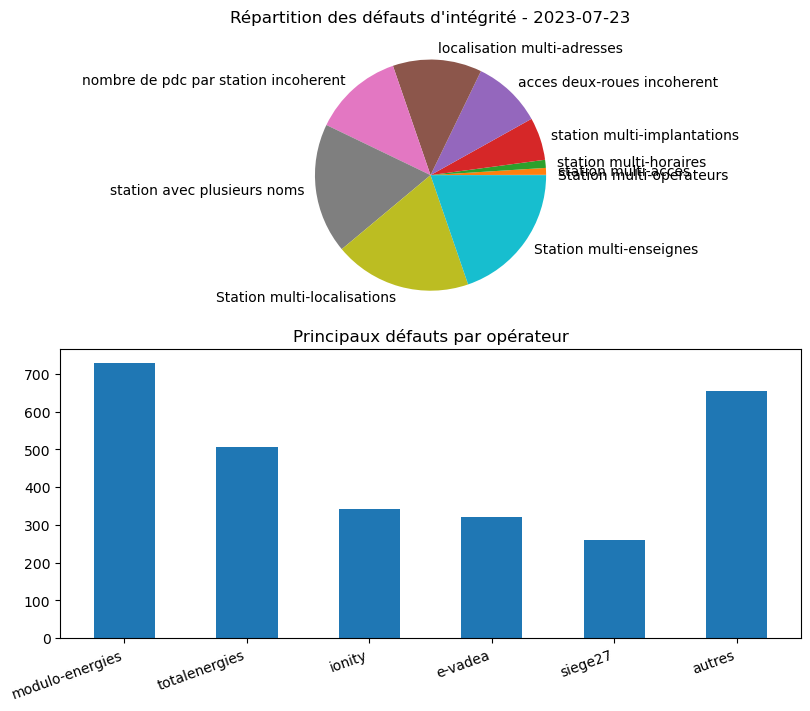

In [7]:
date = defaut_integrite(indic)

## Localisation des stations comportant un écart

### icones de la carte
icones rouge : stations avec un écart de relations entre entités (voir introduction)     
icones orange : stations avec un défaut d'attributs (voir introduction)     

### indicateurs de défauts
Les libellés en fin de fenêtres contextuelles "champ 1 - champ 2 : False" signifient que 
le champ 2 est associé à plusieurs champ 1 en fonction des pdc (défaut d'intégrité).       
       
*Par exemple : "coordonneesXY - id_station_itinerance : False" signifie qu'il existe plusieurs pdc 
avec une même la valeur du champ "id_station_itinerance" mais plusieurs valeurs du champ "coordonnéesXY".*
   
**Nota :** 
- La carte est également accessible et partageable (fichier 'irve.html' présent sur le repository)
- les libellés de défaut sont identiques à ceux du fichier des écarts.


In [10]:
defaut_carte(date).show('irve.html')

## Annexe - Fonctions utilisées

In [ ]:
import json

def indicateurs():
    dic = {}
    with open('logfile.txt', 'r', encoding="utf-8") as f:
        for line in f:
            log = json.loads(line)
            dic[log['date_irve']] = log
    return list(tuple(zip(*sorted(zip(list(dic.keys()),dic.values()))))[1])
    #return list(dic.values())

In [ ]:
import matplotlib.pyplot as plt

def defaut_integrite(indic):
    '''génération d'un graphe présentant la répartition des défauts d'intégrité''' 
    
    defauts = ['Pdc non unique', 'Station multi-operateurs', 'Station multi-enseignes', 'Station multi-localisations', 
               'Pdc multi-stations', 'station avec plusieurs noms', 'station multi-implantations', 
               'nombre de pdc par station incoherent', 'station multi-acces', 'station multi-horaires', 
               'acces deux-roues incoherent', 'localisation multi-adresses']
    val = dict(item for item in indic[-1].items() if item[0] in defauts and item[1] > 0)
    val = dict(sorted(val.items(), key=lambda item:item[1], reverse=False))
    date = indic[-1]['date_irve']
    total = indic[-1]['IRVE_itinerance_residuel' + date + '.csv']
    
    fig, (ax, ax2) = plt.subplots(2, 1, layout='constrained', figsize=(8, 7))
    ax.pie(list(val.values()), labels=list(val.keys()))
    ax.set_title("Répartition des défauts d'intégrité - " + date)
    operateurs = [oper.split(sep='@')[1].split('.')[0] for oper in indic[-1]['operateurs']] + ['autres']
    defauts = indic[-1]['erreurs_operateurs'] + [total - sum(indic[-1]['erreurs_operateurs'])]
    ax2.bar(operateurs, defauts, width=0.5)
    plt.setp(ax2.get_xticklabels(), rotation=20, ha="right")
    ax2.set_title("Principaux défauts par opérateur")
    plt.show()
    return date

In [ ]:
def evolution(log):
    '''génération d'un graphe présentant l'évolution du nombre de pdc valides ou présentant des défauts'''
    
    dic = {}
    for i, indic in enumerate(log):
        if i == 0:
            dic['date'] = []
            dic['pdc defaut'] = []
            dic['pdc valide'] = []
            dic['pdc default %'] = []
        else:
            date = indic['date_irve']
            dic['date'].append(date)
            dic['pdc defaut'].append(indic['IRVE_itinerance_residuel' + date + '.csv'])
            dic['pdc valide'].append(indic['IRVE_itinerance_valide'   + date + '.csv'])
            dic['pdc default %'].append(100 * dic['pdc defaut'][-1] / (dic['pdc defaut'][-1] + dic['pdc valide'][-1]))
    fig, (ax2, ax1) = plt.subplots(2, 1, layout='constrained', figsize=(8, 6))
    ax1.plot(dic['date'], dic['pdc default %'])
    ax1.set_title('Evolution du % de pdc en défaut')
    bottom = [0] * (len(log) - 1)
    ax2.bar(dic['date'], dic['pdc valide'], width=0.5, label='pdc valide', bottom=[0] * (len(log) - 1))
    ax2.bar(dic['date'], dic['pdc defaut'], width=0.5, label='pdc avec défaut', bottom=dic['pdc valide'])
    ax2.set_title("Evolution du nombre de points de recharge IRVE")
    ax2.legend(loc="lower right")
    plt.show()

In [9]:
import pandas as pd
from util_carto import Cart

def defaut_carte(date):
    '''génération d'une carte folium des stations présentant des défauts d'intégrité'''
    
    file = 'IRVE_itinerance_residuel'+date+'.csv'
    #chemin = 'https://raw.githubusercontent.com/loco-philippe/Environmental-Sensing/main/python/Validation/irve/Analyse/'
    #chemin = 'D:\\philippe\\python ESstandard\\Environmental-Sensing\\python\\Validation\\irve\\Analyse\\'
    chemin = 'C:\\Users\\phili\\github\\Environmental-Sensing\\python\\Validation\\irve\\Analyse\\'
    irve = pd.read_csv(chemin + file, sep=',', low_memory=False)
    
    principal = [17, 18, 19, 20, 21]
    irve['principal'] = True
    for ind in principal:
        irve['principal'] &= irve.iloc[:,ind]
    irve_p = irve[~irve['principal']].drop_duplicates('id_station_itinerance').reset_index(drop=True)
    
    secondaire = [22, 23, 24, 25, 26, 27, 28]
    irve['secondaire'] = True
    for ind in secondaire:
        irve['secondaire'] &= irve.iloc[:,ind]
    irve['secondaire'] |= (~irve['principal'] & ~irve['secondaire'])
    irve_s = irve[~irve['secondaire']].drop_duplicates('id_station_itinerance').reset_index(drop=True)
    
    popup = [[], []]
    locat = [[], []]
    vide = {'  ': '  '}
    for ind, irve in enumerate((irve_p, irve_s)):
        for i in range(len(irve)):
            defauts = {irve_p.columns[col]: False  for col in range(17, 29) if not irve.iloc[i,col]}
            popup[ind].append( {'id_station': irve['id_station_itinerance'][i], 
                               'id_pdc': irve['id_pdc_itinerance'][i],
                               'contact_operateur': irve['contact_operateur'][i],
                               'nom_enseigne': irve['nom_enseigne'][i],
                               'nom_station': irve['nom_station'][i],
                               'adresse_station': irve['adresse_station'][i],
                               'fichier des écarts': '<a href="https://github.com/loco-philippe/Environmental-Sensing/blob/main/python/Validation/irve/Analyse/">IRVE_itinerance_residuel</a>',
                               'date du fichier': date } | vide | defauts )
            coord = json.loads(irve['coordonneesXY'][i])
            coord.reverse()
            locat[ind].append(coord)

    cart = Cart([47, 2.5], zoom_start=6)
    cart.add_markers(locat[0], popup=popup[0], color='red', group='écarts entités', max_width=250)
    cart.add_markers(locat[1], popup=popup[1], color='orange', group='écarts attributs', max_width=250, icon='bug')
    return cart